Pre-train the network using *ground truth label* as hint  
Use pre-trained model to continue train on other image data using *rough hint*

In [2]:
%load_ext autoreload
%autoreload 2

import PIL
from PIL import Image
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import matplotlib.pyplot as plt
import skimage
import glob

import torch
import torchvision.utils as vutils
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

from segmentation import Segmentation
from utils.bg_fg_prep import saliency_detect

In [3]:
folder_name = 'brain'

#### Utils Functions
1. pil to np -- np to pil
2. change image size
3. save numpy to image using PIL
4. torch to np
5. change image into three channel
6. saliency_detect give hints

In [4]:
def pil_to_np(img_PIL):
    """Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    """
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.


def np_to_pil(img_np):
    """
    Converts image in np.array format to PIL image.

    From C x W x H [0..1] to  W x H x C [0...255]
    :param img_np:
    :return:
    """
    ar = np.clip(img_np * 255, 0, 255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        assert img_np.shape[0] == 3
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

In [5]:
def change_imgsize(filename, width, height):
    img = Image.open(filename)
    img = img.resize((width, height), PIL.Image.NEAREST)
    img.save(filename)

In [7]:
def save_image(name, image_np, output_path="output/"):
    p = np_to_pil(image_np)
    os.makedirs(output_path, exist_ok=True)
    save_path = os.path.join(output_path, "{}.jpg".format(name))
    p.save(save_path)

In [8]:
def torch_to_np(img_var):
    """
    Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    :param img_var:
    :return:
    """
    return img_var.detach().cpu().numpy()[0]

In [37]:
# transform cell images into three channels

for img in glob.glob('images/'+ folder_name + '/images_1/*.png'):
    image = Image.open(img)
    image = pil_to_np(image)
    image_s = image.squeeze()
    
    test_image = skimage.color.gray2rgb(image_s)
    test_image = test_image.transpose(2, 0, 1)  #    W x H x C to C x W x H
    test_image = np_to_pil(test_image)
    
    name_list = img.split('/')
    os.makedirs('images/'+ folder_name + '/images/', exist_ok=True)
    save_path = 'images/'+ folder_name + '/images/' + name_list[-1]
    
    test_image.save(save_path)
    

In [ ]:
# saliency detection using two threshold for fg and bg

saliency_detect('images/'+ folder_name + '/images/*.png', dest='images/' + folder_name,
               t1=125, t2=25)

#### No need to RUN 
special pre process functions

In [35]:
# For GT boundary: 255 reverse to get gt_bg, gt_fg

for img in glob.glob('images/brain/gt_bg/*.png'):
    lb = Image.open(img)
    lb = pil_to_np(lb)
    lb_r = 1 - lb
    lb_r = np_to_pil(lb_r)
    
    name_list = img.split('/')
    os.makedirs('images/brain/gt_fg/', exist_ok=True)
    save_path = 'images/brain/gt_fg/'+ name_list[-1]
    lb_r.save(save_path)

### USE GT label as hint to pre-train the network

In [8]:
output_path = 'output/resume/' + folder_name

def init_net(img_name, hint_folder='gt', output_path=output_path):
    """return net and optimizer initialized for certain image
    
    hint_folder can be `output` or `gt`
    
    """
    image = Image.open('images/'+ folder_name + '/images/' + img_name)
    bg_hint= Image.open('images/'+ folder_name + '/' + hint_folder + '_bg/' + img_name)
    fg_hint= Image.open('images/'+ folder_name + '/' + hint_folder + '_fg/' + img_name)    
    image = pil_to_np(image)
    bg_hint= pil_to_np(bg_hint)
    fg_hint= pil_to_np(fg_hint)

    net = Segmentation(image_name='images/'+ folder_name + '/images/' + img_name, 
                       image=image, bg_hint=bg_hint, fg_hint=fg_hint,
                       output_path=output_path,
                       plot_during_training=True)
    
    optimizer = torch.optim.Adam(net.parameters, lr=net.learning_rate)
    
    return net, optimizer  # these are not global need to be returned

In [7]:
from tensorboardX import SummaryWriter

In [34]:
net, optimizer = init_net('0000.png')

##### torch summary and graph visualization

In [ ]:
from torchsummary import summary
summary(net.left_net, input_size=(2, 448, 448))

In [ ]:
from torchviz import make_dot
make_dot(net.left_net(net.left_net_inputs[0]), params=dict(net.left_net.named_parameters()))

In [32]:
print(type(net.left_net), net.left_net_outputs[0].shape, net.mask_net_outputs[0].shape)

<class 'torch.nn.modules.container.Sequential'> torch.Size([1, 3, 448, 448]) torch.Size([1, 1, 448, 448])


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.left_net.state_dict():
    print(param_tensor, "\t", net.left_net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

##### Trying `tensorboardX` to show learned_mask and total_loss, psnr

In [35]:
"""First Period:

train the network on 1 image with ground truth as hint
save the model, initialize another model,
load into it and check the performance
""" 
writer = SummaryWriter()

for j in range(4000):
    optimizer.zero_grad()
    net._initialize_step1(j)
    net._step1_optimize_with_hints(j)
    optimizer.step()
    
    net._finalize_iteration(1)
    net._iteration_plot_closure(j)

    writer.add_scalar('loss', net.total_loss, j+1)
    writer.add_scalar('psnr', net.current_psnr, j+1)
    x = vutils.make_grid(net.mask_net_outputs[0], normalize=True, scale_each=True)
    writer.add_image('learned_mask', x, j+1)
    
    if j % 200 == 0:
        save_image('mask_' + str(j), torch_to_np(net.mask_net_outputs[0]), 'output/resume/1')

In [36]:
# Save Model
# loss for second period is keep being low

torch.save({
            'left_state_dict': net.left_net.state_dict(),
            'right_state_dict': net.right_net.state_dict(),
            'mask_state_dict': net.mask_net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': net.total_loss
            }, 'checkpoint.tar')

In [37]:
# Init Model on another image and Load Model

net, optimizer = init_net('0020.png', hint_folder='output')

checkpoint = torch.load('checkpoint.tar')
net.left_net.load_state_dict(checkpoint['left_state_dict'])
net.right_net.load_state_dict(checkpoint['right_state_dict'])
net.mask_net.load_state_dict(checkpoint['mask_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# net.total_loss = checkpoint['loss'] # 'Tensor' object has no attribute 'load_state_dict'

In [38]:
"""Second Period:

without hints not working at all
so use hint to train first 1000 iteration
this 1000 can be changed, maybe influence final performance
then without use simple loss

"""

writer = SummaryWriter()


for j in range(4000):
    optimizer.zero_grad()
    net._initialize_step2(j)
    net._step2_optimize_with_hints(j)
    optimizer.step()
    
    net._finalize_iteration(1)
    net._iteration_plot_closure(j)

    writer.add_scalar('loss', net.total_loss, j+1)
    writer.add_scalar('psnr', net.current_psnr, j+1)
    x = vutils.make_grid(net.mask_net_outputs[0], normalize=True, scale_each=True)
    writer.add_image('learned_mask', x, j+1)
    
    if j % 200 == 0:
            save_image('mask_' + str(j), torch_to_np(net.mask_net_outputs[0]), 'output/resume/2')

# ============================= #

### ORIGINAL PROCESS

In [ ]:
def run_net(img_name, output_path='output/' + folder_name):
    image = Image.open('images/'+ folder_name + '/images/' + img_name)
    image = pil_to_np(image)
    bg_hint= Image.open('images/'+ folder_name + '/output_bg/' + img_name)
    bg_hint= pil_to_np(bg_hint)
    fg_hint= Image.open('images/'+ folder_name + '/output_fg/' + img_name)
    fg_hint= pil_to_np(fg_hint)
    
    net = Segmentation(image_name='images/'+ folder_name + '/images/' + img_name, 
                       image=image, bg_hint=bg_hint, fg_hint=fg_hint,
                       output_path=output_path,
                       plot_during_training=True)
    
    net.optimize()
    net.finalize()

CPU times: user 1h 32min 41s, sys: 6min 22s, total: 1h 39min 4s1   
Wall time: 7min 58s


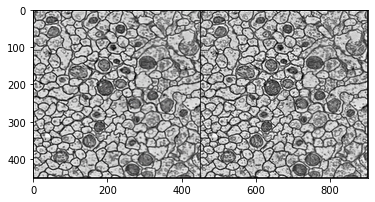

In [19]:
%%time
run_net('0020.png', 'output/' + folder_name + '/125-25')

In [ ]:
cell_list = os.listdir('images/'+ folder_name + '/images')
cell_list = [x for x in cell_list if x.endswith('png')]
cell_list

/home/lanbowen23/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


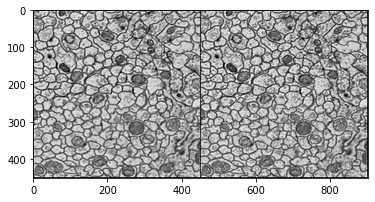

In [16]:
for c in cell_list[:10]:
    run_net(c)